## Module 3 Final Project - Analytical Insights from Northwind Database

The goal of this project is to conduct a statistical analysis and hypothesis test on the Northwind Traders Database - a dataset created by Microsoft for educational purposes for a fictional company that imports and exports specialty foods globally. 

Our main task is to answer to our stakeholders the following question:

**"Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?"**

Besides this question posed by our stakeholders, we are also going to investigate three other hypothesis based on our analysis and understanding of this data.

Our first step in answering the first question is define our null and alternative hypothesis, as well as our alpha value:

**Null Hypothesis** = there is no difference in product quantity order when there is a discount. 

**Alternative Hypothesis** = discount has a statistically significant impact on product quantity order.

**Alpha = 0.05**  - For this test we will accept an alpha value of 0.05, which means that we will accept a 5% change of rejecting the null hypothesis when it is in fact true.

Now we need to load the data we will need to implement our hypothesis analysis.

In [1]:
# import necessary libraries
import pandas as pd
import sqlite3

# connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

We will look at the database schema below in order to query the information we will need.

<img src='Northwind_ERD_updated.png'>

In [2]:
# query database for the relevant information on orders
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount FROM OrderDetail;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(10)

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.00
1,10248,42,9.8,10,0.00
2,10248,72,34.8,5,0.00
3,10249,14,18.6,9,0.00
4,10249,51,42.4,40,0.00
5,10250,41,7.7,10,0.00
6,10250,51,42.4,35,0.15
7,10250,65,16.8,15,0.15
8,10251,22,16.8,6,0.05
9,10251,57,15.6,15,0.05


In [3]:
# check the basic statistics for this data
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


We can see that we have a total of 2155 orders and the mean overall quantity on each order regardless of a discount is of 23.81 products, with a median of 20 products. We can also see that the maximum discount level is of 25%. We will investigate further the discount column.

In [4]:
# verify what levels of discount we have
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

We note that we have some levels of discount that are more common - 5%, 10%, 15%, 20% and 25% - and very few other amounts that we will choose to drop from our analysis since their numbers are too small for us to compare. 

To start, we can separate our data into two different sets - no discount and discount, and analyse if the presence of a discount has an impact on quantity of products on the orders.

In [5]:
# select only the quantity amounts for orders with no discount on a series
no_discount = df.loc[df.Discount == 0, 'Quantity']

no_discount.head()

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

In [6]:
# select rows only on orders that have discount between 5% and 25%
discount_levels = [0.05, 0.10, 0.20, 0.15, 0.25]
discount = df.loc[df.Discount.isin(discount_levels), 'Quantity']

discount.head()

6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64

In [7]:
#check how many datapoints we have
print(f'We have {len(no_discount)} orders with no discount, and {len(discount)} orders with discounts between 5% and 25%.')

We have 1317 orders with no discount, and 830 orders with discounts between 5% and 25%.


Let us have a quick look at the distributions of these data with a simple histogram plot.

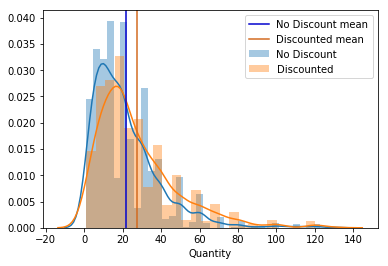

In [92]:
#import vizualization libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#plot both series on a distribution plot
sns.distplot(no_discount, label='No Discount')
sns.distplot(discount, label='Discounted')
plt.axvline(np.mean(no_discount), color='mediumblue', label='No Discount mean')
plt.axvline(np.mean(discount), color='chocolate', label='Discounted mean')
plt.legend()
plt.show()

We can see from the graph that both have an approximate normal distribution. Also, there seems to be a difference in the mean quantity for discounted products as compared to no discount - this is a good sign but we must perform our statistical tests in order to be able to conclude if such difference is statistically significant. Since what we are initially trying to prove is if there is a difference between quantity in orders with and without a discount, a paired two-sample t-test is appropriate, and we will use the mean product quantity as our metric. 

In [9]:
# import libraries
from scipy import stats 
import math

# let's write down our alpha value for reference
alpha = .05

# to start let's simply find the difference in mean for discounted and not discounted orders
no_discount.mean()
discount.mean()
mean_difference = discount.mean() - no_discount.mean()
mean_difference

5.638954908472158

We see that we have a difference of 5.63 in the mean of products for orders with discount as compared to no discount, but we must further investigate if this difference is statistically significant. Before deciding which type of t-test we will use we must check if our two groups have equal variance. We will perform Bartlett’s test to check it - this test tests the null hypothesis that two sample groups have equal variance.

In [10]:
# perform Bartlett test for variance
stats.bartlett(discount, no_discount)

BartlettResult(statistic=29.48129316230489, pvalue=5.645902482998379e-08)

Our result shows that our discount and no_discount groups do not have equal variances. In this case, we must use the 
Welch T-Test in our statistical analysis.

In [11]:
# perform t-test with welch correction
t, p = stats.ttest_ind(discount, no_discount, equal_var = False)

# check our p-value. We divide our p-value result by two because we are interested in one-tailed test (is discount larger?)
print(f'Our p-value is of {p/2}.')

# compare p-value to our alpha in order to check if we can reject the null hypothesis
p/2 < alpha

Our p-value is of 5.0256277704215826e-11.


True

Our test and p-value shows us that we can reject our null hypothesis, so we can say at a 95% confidence level that the mean quantity of products ordered is larger when there is a discount offered. We can now further investigate the different discount levels to answer the second part of the question - **at what level of discount we see an effect on quantity ordered?**

In order to do this, we will separate the different discount levels and compare if there is a significant difference among them using a ANOVA test.

In [12]:
# create separate series for each discount level
disc_05 = df.loc[df.Discount == 0.05, 'Quantity']
disc_10 = df.loc[df.Discount == 0.10, 'Quantity']
disc_15 = df.loc[df.Discount == 0.15, 'Quantity']
disc_20 = df.loc[df.Discount == 0.20, 'Quantity']
disc_25 = df.loc[df.Discount == 0.25, 'Quantity']

In [13]:
# check size of each group
print(f'5% discount: {len(disc_05)} \n10% discount: {len(disc_10)} \n15% discount: {len(disc_15)} \n20% discount: {len(disc_20)} \n25% discount: {len(disc_25)}')

5% discount: 185 
10% discount: 173 
15% discount: 157 
20% discount: 161 
25% discount: 154


We can also quickly have a look at the distribution for each group.

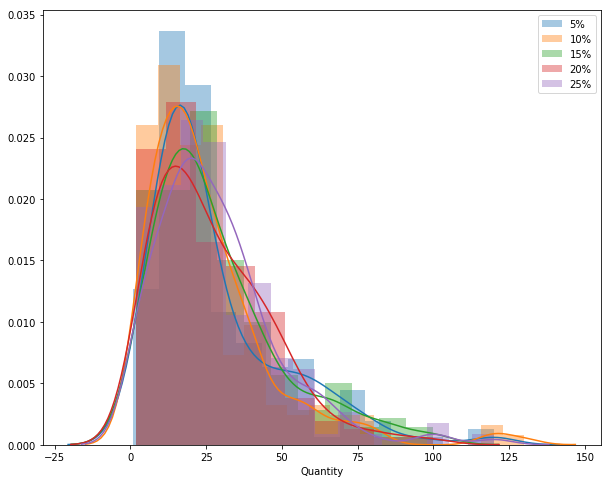

In [14]:
plt.figure(figsize=(10,8))
sns.distplot(disc_05, label='5%')
sns.distplot(disc_10, label='10%')
sns.distplot(disc_15, label='15%')
sns.distplot(disc_20, label='20%')
sns.distplot(disc_25, label='25%')
plt.legend()
plt.show()

They all have a similar shape and are approximatelly normally distributed, although positively skewed. I  want to also have a quick look at their bloxplot to see how they might differ in terms of median and outliers.

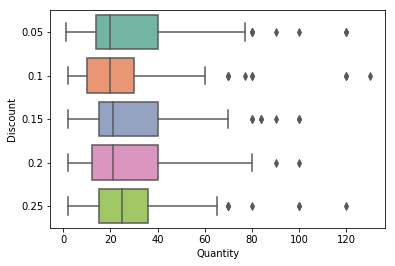

In [34]:
df_discount = df.drop(columns=['OrderId','ProductId','UnitPrice'])
df_discount = df.loc[df.Discount.isin(discount_levels), ['Quantity', 'Discount']]
df_discount.head()

ax = sns.boxplot(x='Quantity', y='Discount', data=df_discount, orient='h', palette='Set2')

The medians seem close and we don't see much separation among the different data. We do see some outliers approximately above 60 itemns, on all levels of discount. 

We can perform a 1-way ANOVA test now to verify if there is a statistically significant difference amongst the different levels of discount for the mean quantity of products ordered.

In [35]:
# run a one way ANOVA test using statsmodels
stats.f_oneway(disc_05, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=0.6741032559876151, pvalue=0.610041445360832)

Our test shows at a 95% confidence level that there is no statistically significant difference amongst the different levels of discounts. To further confirm this, I want to run a t-test comparing each discount level to all the others. Let's write down a function for this task.

In [63]:
# write a function to run several welch's t-tests

def t_test(sample1, sample2, alpha=0.05, two_tailed=False):
    ''' takes two samples and alpha value and runs a simple Welch T-Test, returning corresponding p-value.
    Default alpha is 0.05, can pass a different value as paramter
    Default is for one-tailed but can take a two_tailed parameter as True, then returns two-tailed p-value result.'''
    
    # run t-test with welch correction
    t, p = stats.ttest_ind(sample1, sample2, equal_var = False)
    if two_tailed:
        print(f'Our p-value is of {p}.')
    else:
        print(f'Our p-value is of {p/2}.')

    # compare p-value to our alpha in order to check if we can reject the null hypothesis, 
    # returns False if we fail to reject the null hypothesis
    if two_tailed:
        return print(p < alpha)
    else:
        return print(p/2 < alpha)

In [64]:
# make a list with all the different discount series
list_of_discounts = [disc_05, disc_10, disc_15, disc_20, disc_25]

# run a t-test comparing each level of discount
for i in list_of_discounts:
    for e in list_of_discounts:
        t_test(i,e)

Our p-value is of 0.5.
False
Our p-value is of 0.11355233112599261.
False
Our p-value is of 0.436850968885396.
False
Our p-value is of 0.32755671499068295.
False
Our p-value is of 0.4602966241268858.
False
Our p-value is of 0.11355233112599261.
False
Our p-value is of 0.5.
False
Our p-value is of 0.08808253990239587.
False
Our p-value is of 0.2074729709592535.
False
Our p-value is of 0.09487792002313435.
False
Our p-value is of 0.436850968885396.
False
Our p-value is of 0.08808253990239587.
False
Our p-value is of 0.5.
False
Our p-value is of 0.2719683612710327.
False
Our p-value is of 0.47571144162250883.
False
Our p-value is of 0.32755671499068295.
False
Our p-value is of 0.2074729709592535.
False
Our p-value is of 0.2719683612710327.
False
Our p-value is of 0.5.
False
Our p-value is of 0.29035465628086127.
False
Our p-value is of 0.4602966241268858.
False
Our p-value is of 0.09487792002313435.
False
Our p-value is of 0.47571144162250883.
False
Our p-value is of 0.29035465628086127.


This further confirms that there we cannot reject the null hypothesis that there is no statistically significant difference amongst the different discount levels. So far we learned that discounts do have an effect on quantity ordered, but that the levels of discounts are not statistically significantly different among themselves. 

We can further investigate the effect size of each discount level against a no discount order, to try to grasp which discount level is more effective, since the effect size quantifies the size of the difference between two groups under observation. 

In [65]:
# Import necessary libraries 
import numpy as np

# seed the random number generator so you get the same results
np.random.seed(10)

In [87]:
# define function to calculate the Cohen-d effect size for two samples

def cohen_d(group1, group2):
    
    ''' Compute Cohen's d.
    Transforms pandas series into numpy arrays for calculations
    returns a floating point number for cohen's d. '''
    
    #array_transform(group1, group2)
    
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold 
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return print(f'The Cohen\'s d value is {d}')

In [88]:
for i in list_of_discounts:
    cohen_d(i, no_discount)

The Cohen's d value is 0.3468767736284544
The Cohen's d value is 0.19594203057834086
The Cohen's d value is 0.3724041317472808
The Cohen's d value is 0.3007122542913553
The Cohen's d value is 0.36659255652674416


In [89]:
cohen_d(disc_05, no_discount)
cohen_d(disc_10, no_discount)
cohen_d(disc_15, no_discount)
cohen_d(disc_20, no_discount)
cohen_d(disc_25, no_discount)

The Cohen's d value is 0.3468767736284544
The Cohen's d value is 0.19594203057834086
The Cohen's d value is 0.3724041317472808
The Cohen's d value is 0.3007122542913553
The Cohen's d value is 0.36659255652674416


In [93]:
cohen_d(disc_15, disc_05)

The Cohen's d value is 0.017179350730157576
